## Cpu implementation of convolutional neural network for a trivial binary classification model with Pytorch 

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from torch.optim import SGD
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report

### Upload the dataset 

In [3]:
data = np.load('/Users/marcosalvalaggio/Desktop/TrivialBinaryClassification.npz')
data.files

['X_train', 'X_test', 'y_train', 'y_test']

In [4]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
# Dataset dimensions (num of images, height, width)
print(f'X_train dataset shape: {X_train.shape}')
print(f'X_test dataset shape: {X_test.shape}')

X_train dataset shape: (1600, 100, 100)
X_test dataset shape: (400, 100, 100)


In [6]:
# Labels 
print(y_train.shape)
print(y_test.shape)

(1600,)
(400,)


### Visualize a single image from train dataset 

(-0.5, 99.5, 99.5, -0.5)

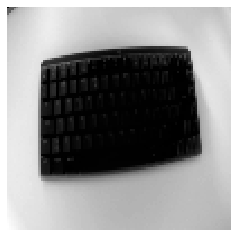

In [9]:
plt.matshow(X_train[100],cmap='gray')
plt.axis('off')

Schema for map y values to category labels:

* keyboard = 0
* mouse = 1 

In [10]:
print(f'X_train[100]: {y_train[100]}')
print(f'Label for X_train[100]: keyboard')

X_train[100]: 0
Label for X_train[100]: keyboard


### Preprocessing 

In [11]:
#Min-max feature scaling = values of single pixel between [0,1] instead of [0 = black , 255 = white]
X_train = X_train / 255
X_test = X_test / 255

In [12]:
# First train dataset image scaled 
X_train[0,:,:]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.41176471, 0.4       ,
        0.30588235],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.41960784, 0.40392157,
        0.31764706],
       [0.01176471, 0.00784314, 0.00392157, ..., 0.42745098, 0.41568627,
        0.31764706],
       ...,
       [0.01960784, 0.12941176, 0.60392157, ..., 0.64313725, 0.63137255,
        0.63529412],
       [0.00784314, 0.00784314, 0.14117647, ..., 0.63529412, 0.63137255,
        0.62745098],
       [0.09411765, 0.00784314, 0.00784314, ..., 0.63137255, 0.62745098,
        0.62745098]])

### Converting into Torch tensors and select the device (cpu or gpu)

In [13]:
# Conversion 
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).float()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)

In [14]:
print(f'X_train Torch tensor: {X_train_t.shape}')
print(f'y_train Torch tensor: {y_train_t.shape}')

X_train Torch tensor: torch.Size([1600, 100, 100])
y_train Torch tensor: torch.Size([1600])


need to obtain an object of dimension [-1,1,100,100]

### Defining dataset class

In [15]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        #self.x = torch.tensor(x).float()
        #self.y = torch.tensor(y, dtype=torch.float)
        self.x = x.view(-1,1,100,100)
        self.y = y.clone().detach().requires_grad_(True)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
# create a MyDataset object 
ds = MyDataset(X_train_t, y_train_t)

### Create the dataloader 

In [16]:
batch_size = 800
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

### Define the network structure 

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidd_to_conv1 = nn.Conv2d(1, 64, kernel_size=5)# (96x96x64) 
        self.maxpool1 = nn.MaxPool2d(2)#(48,48,64)
        self.max_to_conv2 = nn.Conv2d(64,128, kernel_size=5)#(44,44,128)
        self.maxpool2 = nn.MaxPool2d(2)#(22,22,128)
        self.maxpool3 = nn.MaxPool2d(2)#(11,11,128)
        self.flatten = nn.Flatten()
        self.flatten_to_linear = nn.Linear(15488,100)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear(100,1)

    def forward(self, x):
        x = self.hidd_to_conv1(x)
        x = self.maxpool1(x)
        x = self.max_to_conv2(x)
        x = self.maxpool2(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.flatten_to_linear(x)
        x = self.hidden_layer_activation(x)
        x = torch.sigmoid(self.hidden_to_output_layer(x))
        return x


mynet = ConvNet().to(device)

### Forward pass on the untrained network

In [19]:
img = X_train_t[1].view(-1,1,100,100)
print(f'1) size of the image: {img.size()}')
print(f'2) label of the image: {y_train_t[1]} = keyboard')
print(f'3) value of the output node of the network: {mynet(img)}')
print(f'4) predicted class: {torch.round((mynet(img)))} = mouse') # wrong prediction 

1) size of the image: torch.Size([1, 1, 100, 100])
2) label of the image: 0.0 = keyboard
3) value of the output node of the network: tensor([[0.5035]], grad_fn=<SigmoidBackward0>)
4) predicted class: tensor([[1.]], grad_fn=<RoundBackward0>) = mouse


### Define objective function and upgrade weights method 

In [20]:
loss_func = nn.BCELoss()
opt = SGD(mynet.parameters(), lr = 0.001)
epochs = 3

### Training loop

In [21]:
def accuracy_val(y_pred, y_val):

    y_pred_tag = np.array(y_pred.reshape(-1).detach()).round()
    y_val = np.array(y_val.detach())

    correct_results = np.sum(y_pred_tag == y_val)
    acc = correct_results/y_val.shape[0]
    acc = np.round(acc * 100)
    
    return acc

In [23]:
loss_history = []
acc_history = []
mynet.train()
print('===========================================================')
for _ in range(epochs):
    numBatch = np.round(X_train_t.shape[0]/batch_size)
    batch = 1
    for data in dl:

        x, y = data
        opt.zero_grad()

        predicted = mynet(x)
        loss_value = loss_func(predicted, y.unsqueeze(1))
        acc_value = accuracy_val(predicted, y)


        loss_value.backward()
        opt.step()

        loss_history.append(loss_value)
        acc_history.append(acc_value)

        print(f'epoch: {_+1}/{int(epochs)} | batch: {batch}/{int(numBatch)} | loss: {loss_value:.4f} | accuracy: {acc_value}%')

        batch += 1

print('===========================================================')

epoch: 1/3 | batch: 1/2 | loss: 0.6867 | accuracy: 79.0%
epoch: 1/3 | batch: 2/2 | loss: 0.6837 | accuracy: 83.0%
epoch: 2/3 | batch: 1/2 | loss: 0.6815 | accuracy: 85.0%
epoch: 2/3 | batch: 2/2 | loss: 0.6790 | accuracy: 88.0%
epoch: 3/3 | batch: 1/2 | loss: 0.6771 | accuracy: 87.0%
epoch: 3/3 | batch: 2/2 | loss: 0.6750 | accuracy: 91.0%


### Label prediction for a new "virtual" image passed to the trained model 

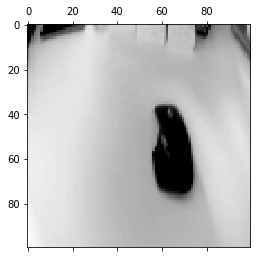

In [24]:
index = 1
plt.matshow(X_test[index],cmap='gray')

In [25]:
print(f'X_test[index]: {y_test[index]}')
print(f'Label for X_test[index]: mouse')

X_test[index]: 1
Label for X_test[index]: mouse


In [26]:
# Conversion 
X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).float()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

In [27]:
# label
y_test[1]

1

In [28]:
# prediction 
img = X_test_t[1].view(-1,1,100,100)
output = mynet(img)
output

tensor([[0.5219]], grad_fn=<SigmoidBackward0>)

In [29]:
# label predicted
torch.round(mynet(img))

tensor([[1.]], grad_fn=<RoundBackward0>)

### Prediction on Test dataset 

In [30]:
X_test_t.shape

torch.Size([400, 100, 100])

In [31]:
X_test_t_res = X_test_t.view(400,1,100,100)

In [32]:
X_test_t_res.shape

torch.Size([400, 1, 100, 100])

In [33]:
pred = mynet(X_test_t_res)

In [34]:
pred = torch.round(pred)

In [35]:
pred.shape

torch.Size([400, 1])

In [36]:
y_pred_test_tag = np.array(pred.reshape(-1).detach()).round()
print(y_pred_test_tag.shape)
y_val_test = np.array(y_test_t.detach())
print(y_val_test.shape)

(400,)
(400,)


In [37]:
confusion_matrix(y_val_test, y_pred_test_tag)

array([[166,  41],
       [  0, 193]])

In [38]:
print(classification_report(y_val_test, y_pred_test_tag))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       207
         1.0       0.82      1.00      0.90       193

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.92      0.90      0.90       400

